In [1]:
import pandas as pd

df = pd.read_csv("annotations.csv.gzip", compression="gzip", index_col=0)
df.head()

,model,lang,manuscript,file,page_id,line_id,baseline,transcription
0,data-lat_only_3.mlmodel,lat,SBB_PK_Hdschr25,SBB_PK_Hdschr25_047v,0,0,175 203 417 206 640 204,a ⁊utl
1,data-lat_only_3.mlmodel,lat,SBB_PK_Hdschr25,SBB_PK_Hdschr25_047v,0,1,292 254 681 254,t ut t̃ ps p
2,data-lat_only_3.mlmodel,lat,SBB_PK_Hdschr25,SBB_PK_Hdschr25_047v,0,2,286 309 677 306,tas t̃
3,data-lat_only_3.mlmodel,lat,SBB_PK_Hdschr25,SBB_PK_Hdschr25_047v,0,3,177 357 461 360 674 356,e ult ut p̃ t
4,data-lat_only_3.mlmodel,lat,SBB_PK_Hdschr25,SBB_PK_Hdschr25_047v,0,4,173 408 670 409,ba tt ss ttta


In [2]:
df[(df.lang == "lat") & (df.model=="GT")].manuscript.unique()

array(['PalLat373', 'CCCC-MSS-236', 'Latin8236', 'SBB_PK_Hdschr25',
       'WettF0015', 'LaurentianusPluteus53.09', 'CLM13027', 'Mazarine915',
       'Egerton821', 'LaurentianusPluteus33.31', 'Arras-861',
       'CCCC-MSS-165', 'Latin16195', 'LaurentianusPluteus53.08', 'H318',
       'Latin6395', 'Phi_10a135', 'BIS-193', 'LaurentianusPluteus39.34'],
      dtype=object)

In [3]:
df[(df.manuscript == "bodmer_168_otinel") & (df.page_id == 5) & (df.line_id == 1)]

,model,lang,manuscript,file,page_id,line_id,baseline,transcription
87708,data-manumffrench2.mlmodel,fro,bodmer_168_otinel,446_663dd_default,5,1,155 649 2110 644,» Lume ar out par oul ne loun met hes
109807,data-bad_0.mlmodel,fro,bodmer_168_otinel,446_663dd_default,5,1,155 649 2110 644,i mtere os r ensne lern mes le
129983,data-CREMMA-Medieval.mlmodel,fro,bodmer_168_otinel,446_663dd_default,5,1,155 649 2110 644,Q uatre at occis par eus ne serra mes liez
151401,data-cremma-medieval_2.mlmodel,fro,bodmer_168_otinel,446_663dd_default,5,1,155 649 2110 644,i Q uatre at occis par eus ne serra mes sier
178711,data-bad_3.mlmodel,fro,bodmer_168_otinel,446_663dd_default,5,1,155 649 2110 644,l uatre at occis par eus ne serri mes siez
199125,data-bad_2.mlmodel,fro,bodmer_168_otinel,446_663dd_default,5,1,155 649 2110 644,l uatre at occis par eus ne serri mes siez
220860,data-lat_only_5.mlmodel,fro,bodmer_168_otinel,446_663dd_default,5,1,155 649 2110 644,s uatregeotas par etis te lermi ies se
240429,data-cremma-medieval_1.mlmodel,fro,bodmer_168_otinel,446_663dd_default,5,1,155 649 2110 644,i Q uatre at occis par eus ne serra mes lier
263348,data-lat_only_4.mlmodel,fro,bodmer_168_otinel,446_663dd_default,5,1,155 649 2110 644,sit nao qtetas pt enis no hors mes he
283691,data-bad_1.mlmodel,fro,bodmer_168_otinel,446_663dd_default,5,1,155 649 2110 644,l uatre at oais par eul ue serri mes liez


In [4]:
df[df.transcription.isna()]

,model,lang,manuscript,file,page_id,line_id,baseline,transcription


In [5]:
#df.groupby(["lang", "manuscript", "page_id", "line_id"]).describe()

# Retrieve each MSS

In [6]:
MODELS = [x for x in df.model.unique().tolist() if x != "GT"]
FILTER = ["lang", "manuscript", "page_id", "line_id"]


df["CER"] = -1.0
#df["CER_NS"] = -1.0
df.loc[df.model == "GT", "CER"] = 0.0
df.loc[df.model == "GT", "CER_NS"] = 0.0

def sort_lines(dataframe: pd.DataFrame) -> pd.DataFrame:
    return dataframe.sort_values(FILTER)

IDS = {
    row: idx
    for idx, (row, *_) in enumerate(df.groupby(FILTER))
}


def get_lines(dataframe, model):
    return {
        tuple([row[key] for key in FILTER]): (row.transcription, idx)
        for idx, row in df[df.model == model].iterrows()
        if tuple([row[key] for key in FILTER]) in IDS
    }


In [7]:
GT_TR = get_lines(df, "GT")

# Compute CER

In [8]:
from nenequitia.metrics import computer_cer

def nospace(s: str) -> str:
    return "".join(s.split())

errors = 0

for model in MODELS:
    for line, (transcription, idx) in get_lines(df, model).items():
        try:
            gt, _ = GT_TR.get(line, (None, None))
            # Some GT does not exist because full page were not transcribed
            if isinstance(transcription, str) and isinstance(gt, str):
                #hypothesis = sort_lines(df[df.model == model]).transcription.tolist()
                #print(computer_cer(transcription, gt), transcription, gt)
                df.at[idx, "CER"] = min(computer_cer(transcription, gt)*100, 100.)
                #df.at[idx, "CER_NS"] = min(computer_cer(nospace(transcription), nospace(gt)), 100.)
            else:
                errors += 1
            #else:
            #    print(model)
        except Exception as E:
            print(E)
            
print(f"GT not found / model {errors / len(MODELS)}")

GT not found / model 285.8


In [9]:

print(df.shape, df[df.CER < 0].shape, df[(df.CER > 0) | (df.model == "GT")].shape)
# By filtering CER > 0 we ignore perfectly known lines or just perfectly predicted line 
#   that could mess up train/test/dev
df = df[(df.CER > 0) | (df.model == "GT")]

(357902, 10) (4287, 10) (322903, 10)


# Save CER

In [10]:
df[["model", "lang", "manuscript", "page_id", "line_id", "transcription", "CER"]].to_csv("cer.csv.gzip", compression="gzip")

# Plot CER

<AxesSubplot:title={'center':'CER'}, xlabel='model'>

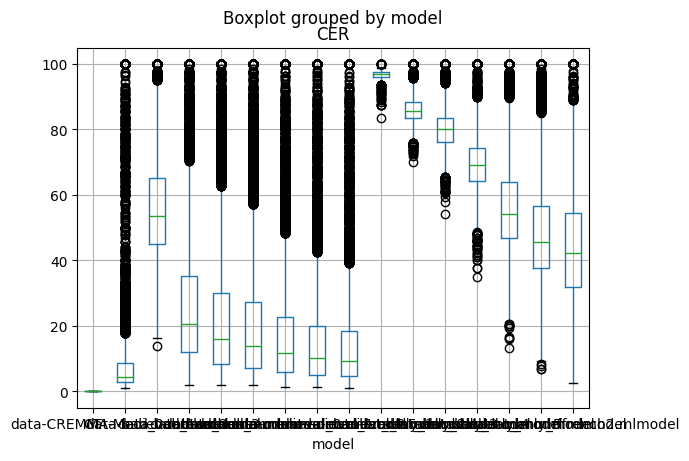

In [11]:
#Cant seem to save
df.boxplot(by="model", column="CER")

In [12]:
df.tail()

,model,lang,manuscript,file,page_id,line_id,baseline,transcription,CER,CER_NS
357897,GT,fro,vaticane_reg_lat_1616_otinel,reg-lat-1616_095r,22,30,302 2713 1269 2713,s ire dit il Otes li sarrasins,0.0,0.0
357898,GT,fro,vaticane_reg_lat_1616_otinel,reg-lat-1616_095r,22,31,321 2785 1255 2790,⁊ sui fiz galien au fier vis,0.0,0.0
357899,GT,fro,vaticane_reg_lat_1616_otinel,reg-lat-1616_095r,22,32,294 2862 1613 2878,m oie est ⁊ la marche ⁊ trestot le pais,0.0,0.0
357900,GT,fro,vaticane_reg_lat_1616_otinel,reg-lat-1616_095r,22,33,310 2952 1415 2960,⁊ benoas qͥ tant est de haut pͥs,0.0,0.0
357901,GT,fro,vaticane_reg_lat_1616_otinel,reg-lat-1616_095r,22,34,305 3032 1316 3037,u ne contree qͥ ml̃t est posteis,0.0,0.0


In [13]:
df.head()

,model,lang,manuscript,file,page_id,line_id,baseline,transcription,CER,CER_NS
0,data-lat_only_3.mlmodel,lat,SBB_PK_Hdschr25,SBB_PK_Hdschr25_047v,0,0,175 203 417 206 640 204,a ⁊utl,82.352942,NaN
1,data-lat_only_3.mlmodel,lat,SBB_PK_Hdschr25,SBB_PK_Hdschr25_047v,0,1,292 254 681 254,t ut t̃ ps p,68.181819,NaN
2,data-lat_only_3.mlmodel,lat,SBB_PK_Hdschr25,SBB_PK_Hdschr25_047v,0,2,286 309 677 306,tas t̃,78.260869,NaN
3,data-lat_only_3.mlmodel,lat,SBB_PK_Hdschr25,SBB_PK_Hdschr25_047v,0,3,177 357 461 360 674 356,e ult ut p̃ t,68.000001,NaN
4,data-lat_only_3.mlmodel,lat,SBB_PK_Hdschr25,SBB_PK_Hdschr25_047v,0,4,173 408 670 409,ba tt ss ttta,70.967740,NaN


In [14]:
df["transcription 	model 	manuscript 	page_id 	line_id 	CER 	lang".split()].sample(frac=1.0).to_hdf("texts.hdf5", key='df')